<a href="https://colab.research.google.com/github/seismosmsr/machine_learning/blob/main/soil_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import geopandas as gpd

In [4]:
file_path = '/content/drive/My Drive/sequence_data.csv'

In [5]:
drivers_gpd = gpd.read_file('/content/drive/MyDrive/hawaii_soils/Analysis Data/250_summary_grid_dt.gpkg')

In [6]:
soils_csv = gpd.read_file('/content/drive/MyDrive/hawaii_soils/HI soils data/combined_soc_2024_04_05.csv')

In [147]:
from shapely.geometry import Point

soils_csv = soils_csv[(soils_csv['latitude'] != '') & (soils_csv['longitude'] != '')]
soils_csv['geometry'] = soils_csv.apply(lambda row: Point(float(row['longitude']), float(row['latitude'] )), axis=1)
soils_gpd = gpd.GeoDataFrame(soils_csv, geometry='geometry', crs="EPSG:4326")

In [240]:


# Ensure both GeoDataFrames have the same CRS
soils_gpd = soils_gpd.to_crs(drivers_gpd.crs)

# Perform spatial join
matched_data = gpd.sjoin_nearest(soils_gpd, drivers_gpd, how='left', distance_col='distance')

In [386]:
# Apply a buffer to each geometry in one of the GeoDataFrames (e.g., soils_gpd)
soils_buffered = soils_gpd.copy()

soils_buffered.geometry = soils_buffered.to_crs(epsg=32604).geometry.buffer(1000).to_crs('ESRI:102261')

# soils_gpd = soils_gpd
# Step 2: Spatial Join
# Perform a spatial join with the buffered GeoDataFrame
# This finds all drivers_gpd points that fall within the 10,000-meter buffer of any point in soils_gpd
matches_within_distance = gpd.sjoin(soils_buffered, drivers_gpd, how='left', op='intersects')


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [242]:
len(soils_gpd)

6842

In [243]:
len(soils_gpd['unique_id'].unique())

6842

In [522]:
reserve_data = matches_within_distance.groupby('unique_id').sample(n=1)

In [521]:
# # Group by 'unique_id' and sample one row from each group
matched_data = matches_within_distance.groupby('unique_id').sample(n=1)

# # Reset index if you want a clean DataFrame index
matched_data = matched_data.reset_index(drop=True)
matched_data['distance'] = 0

In [489]:
# matched_data = unique_sample

In [490]:
unique_rows = matched_data[matched_data["depth_adj_bottom"] == '20']
unique_rows = unique_rows.drop_duplicates(subset=['latitude', 'longitude'])
unique_rows = unique_rows[unique_rows['distance'] < 251]
matched_data = unique_rows

In [491]:
matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]
# matches_within_10000['imp_c_float'] = [float(datum) for datum in matches_within_10000['imp_c']]

In [492]:
# scaled_numeric_df

In [493]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
id_fields = matched_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]

keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48, 55]
# Select only numeric columns
numeric_cols = matched_data.iloc[:,keep_cols]
numeric_cols.replace('', np.nan, inplace=True)
numeric_cols = numeric_cols.astype(float)
numeric_cols.fillna(0, inplace=True)

# Initialize the scaler
scaler = MinMaxScaler ()

# Fit the scaler on the numeric columns
scaler.fit(numeric_cols)

# Transform the numeric columns
scaled_numeric_cols = scaler.transform(numeric_cols)

# Convert the scaled numeric columns back to a DataFrame
scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)

# scaled_numeric_df = scaled_numeric_df
# Concatenate the ID fields back with the numeric columns
numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)

<ipython-input-493-7306ae049bea>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


In [494]:
scaled_numeric_df.columns

Index(['water', 'trees', 'grass', 'flooded_vegetation', 'crops',
       'shrub_and_scrub', 'built', 'bare', 'snow_and_ice', 'elevation',
       'landform', 'SRTM_mTPI', 'aet', 'pdsi', 'pdsi', 'pet', 'pr', 'ro',
       'soil', 'srad', 'swe', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs', 'agbd_m',
       'imp_c_float'],
      dtype='object')

In [495]:
from tensorflow.keras.optimizers import Adam

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split


def real_sequence_generator(data, batch_size):
    while True:
        # Shuffle the data at the beginning of each epoch
        np.random.shuffle(data)
        for i in range(0, len(data), batch_size):
            batch = data[i:i + batch_size]
            # If the batch is smaller than the batch size, pad it with samples from the beginning
            if len(batch) < batch_size:
                padding = data[:(batch_size - len(batch))]
                batch = np.concatenate([batch, padding], axis=0)
            # Separate the input and output sequences
            input_sequences = batch[:, :-1]  # First 3 elements as input
            output_sequences = batch[:, -1]  # Last element as output
            yield input_sequences, output_sequences


train_sequences, val_sequences = train_test_split(scaled_numeric_cols, test_size=0.2, random_state=42)

test_sequences, val_sequences = train_test_split(val_sequences, test_size=0.5, random_state=42)

batch_size = 128  # Set the batch size


# Define the training and validation generators
train_gen = real_sequence_generator(train_sequences, batch_size)
test_gen = real_sequence_generator(test_sequences, batch_size)
val_gen = real_sequence_generator(val_sequences, batch_size)


In [496]:
scaled_numeric_df.to_csv('scaled_df.csv')

In [497]:
# Define the generator model
def build_model(input_sequence_shape, output_sequence_shape):
    model = models.Sequential([
        layers.Dense(256, activation='relu', input_dim=input_sequence_shape),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),  # Dropout layer after the first LeakyReLU
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Dense(output_sequence_shape, activation='linear')
    ])
    return model

In [498]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


In [499]:
# Assuming the last column is the target variable
X = scaled_numeric_df.iloc[:, :-1]
y = scaled_numeric_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [500]:
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(X_train.shape[1],)),

#     Dense(32, activation='relu'),
#     Dense(1, activation='linear')  # Change activation if it's a classification problem
# ])


In [501]:
soc_model = build_model(27,1)

In [502]:
soc_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')  # Change loss if it's a classification problem


In [503]:
history = soc_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)

Epoch 1/100
5/5 [==============================] - 2s 72ms/step - loss: 2.6966 - val_loss: 0.0454
Epoch 2/100
5/5 [==============================] - 0s 20ms/step - loss: 2.3506 - val_loss: 0.0422
Epoch 3/100
5/5 [==============================] - 0s 21ms/step - loss: 2.5095 - val_loss: 0.0374
Epoch 4/100
5/5 [==============================] - 0s 20ms/step - loss: 1.4256 - val_loss: 0.0308
Epoch 5/100
5/5 [==============================] - 0s 20ms/step - loss: 1.6778 - val_loss: 0.0331
Epoch 6/100
5/5 [==============================] - 0s 20ms/step - loss: 1.4286 - val_loss: 0.0341
Epoch 7/100
5/5 [==============================] - 0s 20ms/step - loss: 1.9676 - val_loss: 0.0323
Epoch 8/100
5/5 [==============================] - 0s 20ms/step - loss: 1.2403 - val_loss: 0.0333
Epoch 9/100
5/5 [==============================] - 0s 20ms/step - loss: 1.3583 - val_loss: 0.0352
Epoch 10/100
5/5 [==============================] - 0s 21ms/step - loss: 1.0738 - val_loss: 0.0322
Epoch 11/100
5/5 [=

In [504]:
soc_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')  # Change loss if it's a classification problem


In [505]:
history = soc_model.fit(X_train, y_train, validation_split=0.2, epochs=300, batch_size=128, verbose=1)

Epoch 1/300
5/5 [==============================] - 2s 74ms/step - loss: 0.0927 - val_loss: 0.0249
Epoch 2/300
5/5 [==============================] - 0s 19ms/step - loss: 0.0825 - val_loss: 0.0233
Epoch 3/300
5/5 [==============================] - 0s 19ms/step - loss: 0.0933 - val_loss: 0.0159
Epoch 4/300
5/5 [==============================] - 0s 20ms/step - loss: 0.0916 - val_loss: 0.0147
Epoch 5/300
5/5 [==============================] - 0s 22ms/step - loss: 0.0589 - val_loss: 0.0136
Epoch 6/300
5/5 [==============================] - 0s 22ms/step - loss: 0.1021 - val_loss: 0.0140
Epoch 7/300
5/5 [==============================] - 0s 20ms/step - loss: 0.0931 - val_loss: 0.0133
Epoch 8/300
5/5 [==============================] - 0s 21ms/step - loss: 0.0967 - val_loss: 0.0137
Epoch 9/300
5/5 [==============================] - 0s 21ms/step - loss: 0.0768 - val_loss: 0.0138
Epoch 10/300
5/5 [==============================] - 0s 20ms/step - loss: 0.0792 - val_loss: 0.0138
Epoch 11/300
5/5 [=

In [513]:
soc_model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error')  # Change loss if it's a classification problem


In [514]:
history = soc_model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)

Epoch 1/600
5/5 [==============================] - 2s 70ms/step - loss: 0.0190 - val_loss: 0.0078
Epoch 2/600
5/5 [==============================] - 0s 20ms/step - loss: 0.0232 - val_loss: 0.0077
Epoch 3/600
5/5 [==============================] - 0s 21ms/step - loss: 0.0223 - val_loss: 0.0073
Epoch 4/600
5/5 [==============================] - 0s 20ms/step - loss: 0.0188 - val_loss: 0.0072
Epoch 5/600
5/5 [==============================] - 0s 21ms/step - loss: 0.0221 - val_loss: 0.0071
Epoch 6/600
5/5 [==============================] - 0s 20ms/step - loss: 0.0207 - val_loss: 0.0072
Epoch 7/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0168 - val_loss: 0.0073
Epoch 8/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0227 - val_loss: 0.0075
Epoch 9/600
5/5 [==============================] - 0s 20ms/step - loss: 0.0191 - val_loss: 0.0075
Epoch 10/600
5/5 [==============================] - 0s 21ms/step - loss: 0.0232 - val_loss: 0.0079
Epoch 11/600
5/5 [=

In [515]:
loss = soc_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')


6/6 [==============================] - 0s 4ms/step - loss: 0.0114
Test Loss: 0.011410081759095192


In [516]:
predictions = soc_model.predict(X_test)
predictions = [pred[0] for pred in predictions]

6/6 [==============================] - 0s 3ms/step


In [517]:
# predictions_reshaped = predictions.reshape(-1, 1)
dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Assuming 0.5 is the median value after MinMax scaling
target_column_index = -1  # Assuming the last column is the target variable
dummy_array[:, target_column_index] = predictions

target_column_index = -1  # Assuming the last column is the target variable
dummy_array[:, target_column_index] = predictions

inversed_dummy_array = scaler.inverse_transform(dummy_array)

inversed_predictions = inversed_dummy_array[:, target_column_index]


dummy_array[:, target_column_index] = y_test

inversed_dummy_array = scaler.inverse_transform(dummy_array)


inversed_truth = inversed_dummy_array[:, target_column_index]
# inversed_predictions

In [518]:
from sklearn.metrics import r2_score

# Calculate R-squared
r_squared = r2_score(inversed_truth, inversed_predictions)
print(f'R-squared: {r_squared}')


R-squared: 0.3069800662481561


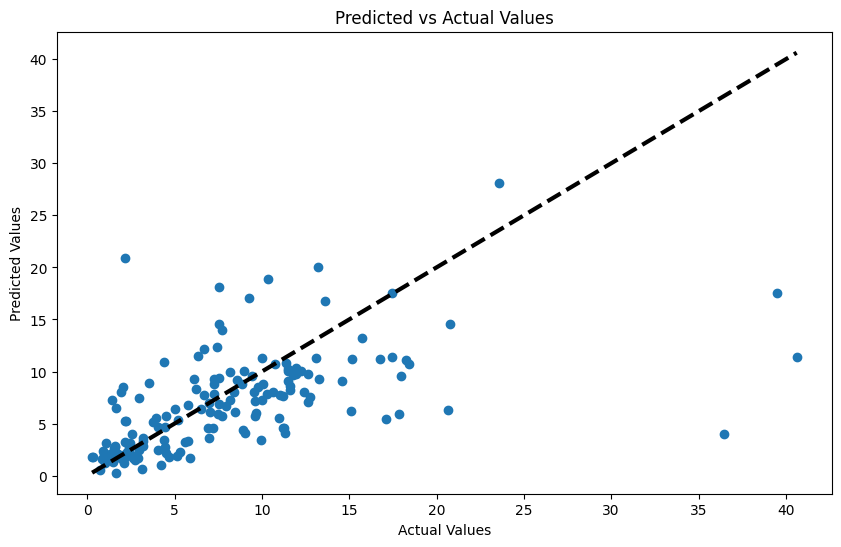

In [519]:
import matplotlib.pyplot as plt

# Make predictions on the test set
# predictions = model.predict(X_test).flatten()

# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.scatter(inversed_truth, inversed_predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.plot([inversed_truth.min(), inversed_truth.max()], [inversed_truth.min(), inversed_truth.max()], 'k--', lw=3)  # Diagonal line
plt.show()
